# Advanced Lane Finding Project
## The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.<br />


In [52]:
#First the imports
import numpy as np
import cv2
import glob #it didn't work with me for some reason in the workspace but let's keep it just in case
import matplotlib.pyplot as plt
import matplotlib.image as mpimg #i will use the plotting method of the previous project

%matplotlib inline
#%matplotlib qt


## Now I'll compute the camera calibration using chessboard images

In [53]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx=9 #number of corners horizontally 
ny=6 #number of corners vertically
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.

objpoints = [] # 3d points in real world space, but the z coordinate has to always be zero, because the pictures were taken on a flat surface
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
# For some reason the global method to upload the images didn't work with me so i'll just do this
images=[]
for i in range(1,21):
    s='/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration'+str(i)+'.jpg'
    #print(s)
    img=mpimg.imread(s)
    images.append(img)
    

# Step through the list and search for chessboard corners

for img in images:
    #First transform to grayScale because this is what the cv2 calibration functions deal with
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp) 
        imgpoints.append(corners)
        #print(corners)

        # Draw and display the corners -Not an important step, just for testing and visualization
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #plt.imshow(img)
        
#NOW i have the corners of all the distorted images, it's time to calculate the calibration matrices

gray=cv2.cvtColor(images[1],cv2.COLOR_BGR2GRAY)
ret,mtx,dist,rvecs,tvecs=cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

#Now that i have the matrices i want to test the undistortion correction, so i'll try it on one of the test images
# The output of my trials will be saved in this path ''
"""
testImageInput=mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')
testImageOutput= cv2.undistort(testImageInput,mtx,dist,None,mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImageInput)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(testImageOutput)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""
#mpimg.imsave('/home/workspace/CarND-Advanced-Lane-Lines/test_images/undistort-output.jpg',testImageOutput )

#Now that the testing worked fine, it means we have a good distortion correction matrices
#Each time i want to undistort a Frame, i call the cv2.undistort(frameImage,mtx,dist,None,mtx) and it returns
#the undistorted frame
#NOW let's head to the next step,Color Space transformation


"\ntestImageInput=mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/camera_cal/calibration10.jpg')\ntestImageOutput= cv2.undistort(testImageInput,mtx,dist,None,mtx)\n\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(testImageInput)\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(testImageOutput)\nax2.set_title('Undistorted Image', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n"

## Now transform images into a suitable Color Space

In [54]:
#I'm going to transform the images into HLS: Hue, Light, Saturation Color Space because i'm expecting the images
#to be in difficult light conditions, so if we exclude the Light from HLS, we should find it easy to know the
# color of objects in the image
#Note to self: i made this step before the perspective transform because i just thought to transform a part of the
#image that's already undistorted and in binary form, is a nicer thing to do.. idk..


#Basically i'm going to get the gradient,and the S channel from the HSL space and combine them to form a binray image

#First upload all the images 

testImages=[]
testImages.append(mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg'))
testImages.append(mpimg.imread('/home/workspace/CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg'))


for i in range(1,7):
    s='/home/workspace/CarND-Advanced-Lane-Lines/test_images/test'+str(i)+'.jpg'
    #print(s)
    img=mpimg.imread(s)
    testImages.append(img)
    
#Make a function that returns the gradient of the image, through combining 3 methods: - Absolute of gradient x,y
# - The mag of both - The direction of gradient
    
def get_abs_mag_dir_binary(image, abs_thresh=(0, 255),mag_thresh=(0, 255),dir_thresh=(0, np.pi/2),sobel_kernel=3):
    
    ###First The magnitude part
    
    #First grayScale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    #Get the "derivative" in the x direction
    sobelx=cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely=cv2.Sobel(gray,cv2.CV_64F, 0,1,ksize=sobel_kernel)
    
    #idk if getting the mag is better or if getting sobelx only is better, but will try out everything, so let's see 
    mag= np.sqrt((sobelx**2)+(sobely**2))
    magScaled= np.uint8(mag*255/np.max(mag))
    
    magBinaryOutput= np.zeros_like(magScaled)
    magBinaryOutput[(magScaled>=mag_thresh[0]) & (magScaled<=mag_thresh[1])]=1
    
    
    ##Second For the Direction part
    
    sobelx_abs=np.absolute(sobelx)
    sobely_abs=np.absolute(sobely)  
    
    
    direction=np.arctan2(sobely_abs,sobelx_abs) 
    
    dirBinaryOutput=np.zeros_like(direction)
    dirBinaryOutput[(direction>=dir_thresh[0]) & (direction<=dir_thresh[1])]=1 
    
    #Finally for the ABSOLUTE PART
    abs_scaled =np.uint8(255*sobelx_abs/np.max(sobelx_abs)) 
    absBinary= np.zeros_like(abs_scaled)
    absBinary[(abs_scaled>= abs_thresh[0]) & (abs_scaled <= abs_thresh[1])] =1
    
    #NOW COMBINE
    combined = np.zeros_like(dirBinaryOutput)
    #combined[(absBinary == 1) |((magBinaryOutput == 1) & (dirBinaryOutput == 1))] = 1
    #combined[(absBinary == 1) &(  (dirBinaryOutput == 1))] = 1
    
    # as i can see my best result obtained without the direction part, so let's just ignore it
    # (of course for better code speed efficiency i should comment or delete it)

    combined[(absBinary == 1) |((magBinaryOutput == 1) )] = 1


    
    
    return absBinary

#Now create a function that returns and image transformed into HSL domain with the S only. (After testing various combinations)
def get_s_binary(img, s_thresh=(0, 255)):
    
    hls=cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    #I remember from the quizes and my trials that the S channel was the best in different lighting conditions so..
    s=hls[:,:,2]
    

    binary_output=np.zeros_like(s)
    binary_output[(s>s_thresh[0]) & (s<=s_thresh[1])]=1 
    
    
    return binary_output

#TESTING
"""
outt=get_abs_mag_dir_binary(testImages[6],abs_thresh=(20,100),mag_thresh=(200, 255),dir_thresh=(0.7, 1.3))
#outt=get_s_binary(testImages[6],s_thresh=(165,255))
#plt.imshow(outt)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImages[6])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(outt, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
"""



#Now let's define a function that transforms each frame/image into my combined binary frame/image
def getCombinedBinary(image,Abs_Thresh=(15,100),Mag_Thresh=(100, 255),Dir_Thresh=(0.7, 1.3),S_Thresh=(170,255),Sobel_Kernel=3):
   
    outt1=get_abs_mag_dir_binary(image,abs_thresh=Abs_Thresh,mag_thresh=Mag_Thresh,dir_thresh=Dir_Thresh,sobel_kernel=Sobel_Kernel)
    outt2=get_s_binary(image,s_thresh=S_Thresh)
    
    combined = np.zeros_like(outt2)
    combined[((outt1 == 1) | (outt2 == 1))] = 1

    return combined
"""
#TESTING
#FIRST FIX THE IMAGE DISTORTION
image_=cv2.undistort(testImages[5],mtx,dist,None,mtx)
    
outt=getCombinedBinary(image_)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(testImages[5])
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(outt, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
   
"""
#Now we test this pipeline on the 8 images in the examples directory


"\n#TESTING\n#FIRST FIX THE IMAGE DISTORTION\nimage_=cv2.undistort(testImages[5],mtx,dist,None,mtx)\n    \noutt=getCombinedBinary(image_)\nf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))\nf.tight_layout()\nax1.imshow(testImages[5])\nax1.set_title('Original Image', fontsize=50)\nax2.imshow(outt, cmap='gray')\nax2.set_title('Thresholded Magnitude', fontsize=50)\nplt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)\n   \n"

## Now time for Perspective Transform

In [55]:
#Let's pick an area that most probably represents a rectangle in the real world 
#Let's define a function for transforming each image
def persp_trans(img):
    img_size=(img.shape[1],img.shape[0])
     
# These hard coded values are after a lot of testing
    src=np.float32(
        [[195,img.shape[0]],   #Low_Left
         [1140,img.shape[0]],   #Low_Right
         [550,470],            #Up_Left
         [720,470]])           #Up_Right
    
    offset=300
    
    dst=np.float32(
        [[offset,img.shape[0]],
         [img.shape[1]-offset,img.shape[0]],
         [offset,offset],
         [img.shape[1]-offset+50,offset]])
    #For warpping
    M = cv2.getPerspectiveTransform(src, dst)
    #Inverse for the unwarpping
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

#TEST
"""
image_=cv2.undistort(testImages[5],mtx,dist,None,mtx)
    
outt=getCombinedBinary(image_)
pres_trans_output,m,minv=persp_trans(outt)
plt.imshow(pres_trans_output)
"""

'\nimage_=cv2.undistort(testImages[5],mtx,dist,None,mtx)\n    \noutt=getCombinedBinary(image_)\npres_trans_output,m,minv=persp_trans(outt)\nplt.imshow(pres_trans_output)\n'

### Now we (suppose that we) have a reasonable lane detection, curvature calculation, pos estimation let's warp the image back and do the visual supporting to each frame

In [56]:
# Create a function that After computing the polynomials and getting the lanes correctly and all,
#draws a polygon to fill the area between the lanes,
#unwarps it, then weights it on the original image.

def unwarp(undist,warped,left_fitx,right_fitx,ploty,Minv,lefty=0,leftx=0,righty=0,rightx=0):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    
    color_warp=warp_zero
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #For some reason the colors would appear unless i re-color them here, maybe if i double check i will fix it later
    color_warp[lefty, leftx] = [255, 0, 0]   #RED LEFT CURVE
    color_warp[righty, rightx] = [0, 0, 255] #BLUE RIGHT CURVE
    #print(lefty)


    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    
    return result
    #return warped


## Now let's apply our algorithms to detect the lane lines
### First the histogram peaks, the window search

In [57]:
#This function is to detect the lanes pixels using the sliding window algorithm.

#Basically what this algorithm does is that it using a start/base point for each lane line,
#draws a virtual window around this start point, and computes the number of nonzero pixels within it,
#if it exceeds a certain margin, we recenter it on the mean coordinate of these points,
#this way the window will keep moving up the frame and we will keep storing nonzero pixels of the lane,
#so eventually we will have lists of the lane pixels.

def find_lane_pixels(img):
    
    #First we compute a histogram by summing all the values vertically corresonding to every x coordinate in
    # the each frame, this way we can tell at which x coordinate exactly the biggest nonzero pixels exist
    # and so we can get a starting point of each lane line
    
    pres_trans_output=img/255
    bottom_half=pres_trans_output[img.shape[0]//2:,:]
    
    histogram=np.sum(bottom_half,axis=0)
    
    out_img = np.dstack((img, img, img))
    #out_img=img
    
    #Now pick a point to in the middle of the left half and the right half as a starting point
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    for_veh_pos=[]
    for_veh_pos.append(midpoint)
    for_veh_pos.append(leftx_base)
    for_veh_pos.append(rightx_base)
    
    #Now determined the parameters of the window
    #HYPERPARAMETERS
    nwindows=9
    margin=100
    minpix=50
    window_height = np.int(img.shape[0]//nwindows)
    
    #Determine the nonzero pixels in the whole wraped binary image  
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Update the current x coordinate of the center of the window  
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #Now iterate for each window
    for window in range(nwindows):
        #First identify the boundaries of each virtual window
        
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        
        win_xleft_low = leftx_current-margin
        win_xleft_high = leftx_current+margin
        win_xright_low = rightx_current-margin
        win_xright_high = rightx_current+margin
        
        """
        #Now draw rectangles, but this is just for visualization it's not important for the pipeline
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        """
        #Extract the nonzero points which are inside each window (simple geometry)#
        good_left_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        #Now this is like a list for each window, append it to an integration array
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #Recenter window if the number of nonzero pixels found inside of it is larger than minpix(let's tune this part as well)#
        
        if len(good_left_inds)> minpix :
            leftx_current=np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix :
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))
        
    #Now this is the end of our iteration over each window
    #Let's combine all the lane pixles found into one integration list
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully,, i kept this because
        #If no pixles were found (just mere error handling)
        pass
    
    #Now that we have a right and a left list that represent the lane's pixles(in a 0 or 1 form allover the nonzero arrays as i understood)#
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img,for_veh_pos


        
    
    
    
    



    
#TEST
#plt.plot(histo(pres_trans_output)) #this is when it only returned a histogram plot 
#leftx, lefty, rightx, righty, out_img=find_lane_pixels(pres_trans_output)
#outtt=np.dstack((np.zeros_like(out_img),out_img,pres_trans_output))
#out_img[lefty, leftx] = [255, 0, 0]
#out_img[righty, rightx] = [0, 0, 255]

#plt.imshow(out_img)


##  Now let's apply our fitting polynomial algorithm and calculate the curvature in the pixel space

In [58]:
#This is the earliest version of the this function you can ignore it
#But anyways basically what it does is that it gets the pixels detected by the last function,
# and fits a polynomial to it, then starts calculating the radius or curvature, the vehicle's position
# relative to the center of the lane, and the horizontal distance between the detected lane lines.
def fit_poly(img,undist,Minv):
    #First of course call the window algorithm function to determined the pixles
    leftx, lefty, rightx, righty, out_img,for_veh_pos=find_lane_pixels(img)
    
    #As we can see, it returns lists of points which are supposed to form a curve, so let's fit a curve to them
    #Let's assume the equation is of degree 2 
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    #now forget about the pixels we got before -for a while-, now we have a curve!
    #Let's generate y values for this curve
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    #Let's get the correspoinding x values of each curve 
    #Simple algebra this is done by substituting the ploty (y values) in the curve's equation
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        #If that happen's let's assume the coefficients ourselves to be ones
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
        
    #This part is for visualization it's not important for the pipeline
    out_img[lefty, leftx] = [255, 0, 0]   #RED LEFT CURVE
    out_img[righty, rightx] = [0, 0, 255] #BLUE RIGHT CURVE

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    #
    #
    #
    #
    
    #NOW for the curve calculation part
    """
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    y_eval = np.max(ploty)
    
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
   
    
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix+left_fit[1])**2))**1.5/np.absolute(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix+right_fit[1])**2))**1.5/np.absolute(2*right_fit[0])
    """
    
    # Define conversions in x and y from pixels space to meters
    my = 30/700 # meters per pixel in y dimension
    mx = 3.7/600 # meters per pixel in x dimension
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    #y_eval = np.max(ploty)*my
    #print(y_eval)
    y_eval=700
    
    #Let's use the student's approach
    
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    
    left_fit[0]= mx/(my**2)*left_fit[0]
    right_fit[0]=mx/(my**2)*right_fit[0]
    
    left_fit[1]=(mx/my)*left_fit[1]
    right_fit[1]=(mx/my)*right_fit[1]
    
    #Now we have the curves in the real world dimensions, we can substitute in the curvature equation with ease
    left_curverad = (1+(2*left_fit[0]*y_eval+left_fit[1])**2)**(3/2)/ (np.absolute(2*left_fit[0]))
    right_curverad =  (1+(2*right_fit[0]*y_eval+right_fit[1])**2)**(3/2)/ (np.absolute(2*right_fit[0])) 
    
    
    #print(left_curverad,'m', right_curverad,'m')
    radius=(left_curverad+right_curverad)/2
    #text1='Radius of Curvature is =' +str(radius)+'m'
    #z = “In the basket are %s and %s” % (x,y)
    text1="Radius of Curvature is = %.2f m" %radius 
    
    #NOW let's try to calculate the vehicles position with respect to the lane's center
    lanes_mid=(for_veh_pos[1]+for_veh_pos[2])//2
    frame_mid=for_veh_pos[0]
    veh_pos_pixel= lanes_mid-frame_mid
    veh_pos_m = veh_pos_pixel*mx
    veh_pos_m=abs(veh_pos_m)
    if veh_pos_pixel>0 : #positive this means the vehicle is shifted left (because the lanes_mid is larger)
        #print('vehicle approximately shifted left with',veh_pos_m,'m')
        #text2='vehicle approximately shifted left with',str(veh_pos_m),'m'
        text2= "Vehicle is %.2f m left of the center " %veh_pos_m
    
    elif veh_pos_pixel<0: #negative this means the vehicle is shifted right
        #print('vehicle approximately shifted right',veh_pos_m,'m')
        #text2='vehicle approximately shifted right',str(veh_pos_m),'m'
        text2="Vehicle is %.2f m right of the center" %veh_pos_m
    elif veh_pos_pixel == 0: #Centered correctly
        #print('vehicle approximately centered')
        text2='Vehicle approximately centered'
        
        
    
    
    
    #NOW TO UNWARP THE FRAAAAAAME YA RAB
    unwarpped=unwarp(undist,out_img, left_fitx, right_fitx, ploty,Minv,lefty,leftx,righty,rightx)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (11,100)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 3

    cv2.putText(unwarpped,text1, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    
    bottomLeftCornerOfText = (11,150)
    
    cv2.putText(unwarpped,text2, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    

    
   

    return unwarpped

"""
##Testing
out_img = fit_poly(pres_trans_output)

plt.imshow(out_img)
   """ 
    
    

'\n##Testing\nout_img = fit_poly(pres_trans_output)\n\nplt.imshow(out_img)\n   '

In [72]:
#After detecting the lane pixels, this function's job is to get change the lane pixels colors them in Red
#for the Left Lane and in Blue for the Right Lane,finds a polynomial that fits them,
#Then it starts the calculations of the lanes' curatures, vehicle's position relative to the center,
#and the distance between the two lanes,
#then the function calls the unwarpping function, and prints out the texts that imply the calculations outputs.
def advanced_fit_poly(img,undist,Minv):
    
    #First of course call the window algorithm function to determined the pixles
    leftx, lefty, rightx, righty, out_img,for_veh_pos=find_lane_pixels(img) #Window Method
    
    #As we can see, it returns lists of points which are supposed to form a curve, so let's fit a curve to them
    #Let's assume the equation is of degree 2 
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    
    #these two lines are because i need these values and i'm afraid they might change by the end of the fn.
    return_left_fit=left_fit
    return_right_fit=right_fit
    
    
    #now forget about the pixels we got before -for a while-, now we have a curve!
    #Let's generate y values for this curve
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    #Let's get the correspoinding x values of each curve 
    #Simple algebra this is done by substituting the ploty (y values) in the curve's equation
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        #If that happen's let's assume the coefficients ourselves to be ones
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
        
    #This part is for visualization it's not important for the pipeline
    out_img[lefty, leftx] = [255, 0, 0]   #RED LEFT CURVE
    out_img[righty, rightx] = [0, 0, 255] #BLUE RIGHT CURVE

    
    #
    #
    #
    #
    
    #NOW for the curve calculation part
    
    # Define conversions in x and y from pixels space to meters
    my = 30/700 # meters per pixel in y dimension
    mx = 3.7/600 # meters per pixel in x dimension
    
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    #y_eval = np.max(ploty)*my
    #print(y_eval)
    y_eval=700
    
    #Let's use the student's approach
    
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    left_fit_meter_coeff0=mx/(my**2)*left_fit[0]
    right_fit_meter_coeff0=mx/(my**2)*right_fit[0]
    
    left_fit_meter_coeff1=(mx/my)*left_fit[1]
    right_fit_meter_coeff1=(mx/my)*right_fit[1]
    
    
    #Now we have the curves in the real world dimensions, we can substitute in the curvature equation with ease
    left_curverad = (1+(2*left_fit_meter_coeff0*y_eval+left_fit_meter_coeff1)**2)**(3/2)/ (np.absolute(2*left_fit_meter_coeff0))
    right_curverad =  (1+(2*right_fit_meter_coeff0*y_eval+right_fit_meter_coeff1)**2)**(3/2)/ (np.absolute(2*right_fit_meter_coeff0)) 
    
    
    radius=(left_curverad+right_curverad)/2
    text1="Radius of Curvature is = %.2f m " %radius 
    
    
    
    #NOW let's try to calculate the vehicles position with respect to the lane's center
    lanes_mid=(for_veh_pos[1]+for_veh_pos[2])//2
    frame_mid=for_veh_pos[0]
    veh_pos_pixel= lanes_mid-frame_mid
    veh_pos_m = veh_pos_pixel*mx
    veh_pos_m=abs(veh_pos_m)
    
    if veh_pos_pixel>0 : #positive this means the vehicle is shifted left (because the lanes_mid is larger)
        text2= "Vehicle is %.2f m left of the center " %veh_pos_m
    
    elif veh_pos_pixel<0: #negative this means the vehicle is shifted right
        text2="Vehicle is %.2f m right of the center" %veh_pos_m
    elif veh_pos_pixel == 0: #Centered correctly
        text2='Vehicle approximately centered'
        
        
    
     #For Horizontal distance (Sanity Check)
    horizontal_distance=abs(for_veh_pos[1]-for_veh_pos[2]) *mx
    
    
    #NOW TO UNWARP THE FRAAAAAAME YA RAB
    
    unwarpped=unwarp(undist,out_img, left_fitx, right_fitx, ploty,Minv,lefty,leftx,righty,rightx)
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (11,100)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 3

    cv2.putText(unwarpped,text1, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    
    bottomLeftCornerOfText = (11,150)
    
    cv2.putText(unwarpped,text2, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    

        

    return unwarpped,return_left_fit, return_right_fit,radius,veh_pos_m,left_curverad,right_curverad,horizontal_distance

"""
##Testing
out_img = fit_poly(pres_trans_output)

plt.imshow(out_img)
   """ 
    
    

'\n##Testing\nout_img = fit_poly(pres_trans_output)\n\nplt.imshow(out_img)\n   '

In [76]:
# what this function does is that it receives averaged polynomials and creates an area around it, detects the 
#lane pixles within it ,changes their colors to Red for the Left Lane and in Blue for the Right Lane,
#finds a polynomial that fits them, Then it starts the calculations of the lanes' curatures,
#vehicle's position relative to the center, and the distance between the two lanes (For sanity checks that
# the detection is sane and acceptable so far), then the function calls the unwarpping function,
# then prints out the texts that imply the calculations outputs.

def without_window(img,left_fit,right_fit,undistorted_frame,Minv_):
    
    #FIRST LET'S GET A (LET'S CALL IT A GREEN AREA WHICH IS THE CLEARANCE WE'RE GOING TO SEARCH FOR THE LANES AROUND)
    
    #first let's get (x,y) points to define the green area
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[2] +left_fit[1]*ploty+left_fit[0]*ploty**2
    right_fitx= right_fit[2]+right_fit[1]*ploty+right_fit[0]*ploty**2
    
    
    green_area_margin=100 #pixels
    
    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Now get the nonzero pixles only if they're in the green area 
    
    #First get their place
    left_lane_inds = []
    right_lane_inds = []
    left_lane_inds = ((nonzerox > (left_fit[2]+left_fit[1]*nonzeroy+left_fit[0]*nonzeroy**2-green_area_margin) )&(nonzerox<(left_fit[2]+left_fit[1]*nonzeroy+left_fit[0]*nonzeroy**2+green_area_margin)))
    right_lane_inds = ((nonzerox > (right_fit[2]+right_fit[1]*nonzeroy+right_fit[0]*nonzeroy**2-green_area_margin)) &(nonzerox<(right_fit[2]+right_fit[1]*nonzeroy+right_fit[0]*nonzeroy**2+green_area_margin)))
    
    #Now get the values
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    #Now fit a new polynomial according to these new points 
    #and get points along this polynomial
    
    new_left_fit = np.polyfit(lefty,leftx,2)
    new_right_fit = np.polyfit(righty,rightx,2)
    
    new_ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    new_left_fitx = new_left_fit[2] +new_left_fit[1]*new_ploty+new_left_fit[0]*new_ploty**2
    new_right_fitx= new_right_fit[2]+new_right_fit[1]*new_ploty+new_right_fit[0]*new_ploty**2
    
    #color points
    poly_colored_img=np.dstack((img,img,img))*255
    #poly_colored_img = np.zeros_like(img)
    # Color in left and right line pixels
    poly_colored_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    poly_colored_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    
    # Define conversions in x and y from pixels space to meters
    my = 30/700 # meters per pixel in y dimension
    mx = 3.7/600 # meters per pixel in x dimension
    y_eval=700
    
    #Let's use the student's approach
    
    #x= mx / (my ** 2) *a*(y**2)+(mx/my)*b*y+c
    
    
    new_left_fit_meter_coeff0= mx/(my**2)*new_left_fit[0]
    new_right_fit_meter_coeff0=mx/(my**2)*new_right_fit[0]
    
    new_left_fit_meter_coeff1=(mx/my)*new_left_fit[1]
    new_right_fit_meter_coeff1=(mx/my)*new_right_fit[1]
    
    #Now we have the curves in the real world dimensions, we can substitute in the curvature equation with ease
    left_curverad = (1+(2*new_left_fit_meter_coeff0*y_eval+new_left_fit_meter_coeff1)**2)**(3/2)/ (np.absolute(2*new_left_fit_meter_coeff0))
    right_curverad =  (1+(2*new_right_fit_meter_coeff0*y_eval+new_right_fit_meter_coeff1)**2)**(3/2)/ (np.absolute(2*new_right_fit_meter_coeff0)) 
    
    
    #print(left_curverad,'m', right_curverad,'m')
    radius=(left_curverad+right_curverad)/2
    text1="Radius of Curvature is = %.2f m " %radius 
    
    #NOW let's try to calculate the vehicles position with respect to the lane's center
    left_lane_x=new_left_fit[2] +new_left_fit[1]*img.shape[0]+new_left_fit[0]*img.shape[0]**2
    right_lane_x=new_right_fit[2] +new_right_fit[1]*img.shape[0]+new_right_fit[0]*img.shape[0]**2
    
    lanes_mid=(left_lane_x+right_lane_x)/2
    
    frame_mid=img.shape[0]/2
    
    veh_pos_pixel= lanes_mid-frame_mid
    veh_pos_m = veh_pos_pixel*mx 
    #The 0.75 is because i noticed there's an error around this value
    veh_pos_m=abs(abs(veh_pos_m) -1.25)
    
    if veh_pos_pixel>0 : #positive this means the vehicle is shifted left (because the lanes_mid is larger)
        text2= "Vehicle is %.2f m left of the center " %veh_pos_m
    
    elif veh_pos_pixel<0: #negative this means the vehicle is shifted right
        text2="Vehicle is %.2f m right of the center" %veh_pos_m
    elif veh_pos_pixel == 0: #Centered correctly
        text2='Vehicle approximately centered'
        
        
    
     #For Horizontal distance (Sanity Check)
    horizontal_distance=abs(left_lane_x-right_lane_x) *mx
    
    
    #NOW TO UNWARP THE FRAAAAAAME YA RAB
    unwarpped=unwarp(undistorted_frame,poly_colored_img, new_left_fitx, new_right_fitx, new_ploty,Minv_,lefty,leftx,righty,rightx)
    
    
    #PRINT THE NUMERIC VALUES
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (11,100)
    fontScale              = 2
    fontColor              = (255,255,255)
    lineType               = 3

    cv2.putText(unwarpped,text1, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    
    
    bottomLeftCornerOfText = (11,150)
    
    cv2.putText(unwarpped,text2, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
    

        
    

    return unwarpped,new_left_fit, new_right_fit,radius,veh_pos_m,left_curverad,right_curverad,horizontal_distance

"""
##Testing
out_img = fit_poly(pres_trans_output)

plt.imshow(out_img)
   """ 
    
    

'\n##Testing\nout_img = fit_poly(pres_trans_output)\n\nplt.imshow(out_img)\n   '

## Pipeline to test images  

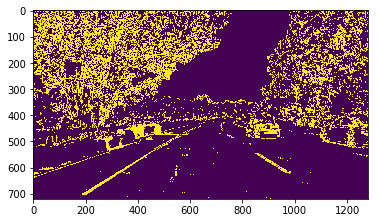

In [61]:
#Remember the test images were uploaded in the Color Space cell
#First the distortion and the color space 

testtest=testImages[6]

#FIRST FIX THE IMAGE DISTORTION
image_=cv2.undistort(testtest,mtx,dist,None,mtx)

binImg=getCombinedBinary(image_)

plt.imshow(binImg)

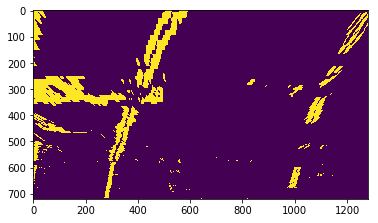

In [62]:
pres,M_,Minv_=persp_trans(binImg)
plt.imshow(pres)

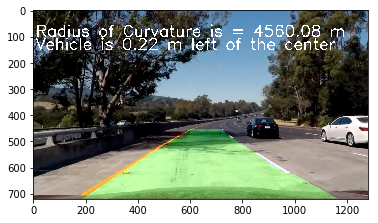

In [63]:
outimg = fit_poly(pres,image_,Minv_)



plt.imshow(outimg)


## Let's add the class that shall help us when detecting lanes becomes a rough job

In [64]:
#THIS CELL IS TO COLLECT MY THOUGHTS
# Now my scenario is 
# Receive uhmm 5 frames and process them through the regular testImages pipeline, then record the output lines-data
# in an array of Line objects (size 5),, uh right, before accepting each object data, it should be validated
# which means it should pass the sanity checks: - similar curvature values - seperated by a reasonable horizontal
# distance - roughly paralell(i think it's the same as similar curvature lol)
# so when this 'first 5 frames' stage finishes ; 

# we head to the stage of relying on them, or not.. honestly idk what they mean by saying "search around the detected area"
# like okay i can get the polynomial okay, i can get some extra clearance around it okay, but how do i search
# for lanes in that area alone? do I, like do the edge detection and accept the pixels that are only in that area?
# well that sounds like a nice applicable plan uhmm then after that what? you got some pixles, use them to what?
# i mean you can't get the polynomial because to do so, you need to do the perspective transformation first
# and if you do this, then duh you only have the sliding window part to ignore so i don't think this is a good
# optimization plan,,,,,, so what do we do?
# Uh wait, apparatenly skippiing the sliding window part is what is actually expected from me, is it? idk.. 
# But it's all that's in my mind right now so let's go for it

# So after getting 5 reliable readings, i will get the average of them, and then add some clearance on both sides
# to form an area that we will be searching for the lanes inside of it for the next uhmmm frames till when?
# well, i assume this should work for the whole video.. but will see..
# so this "search" will be another pipeline of - undistortion- edge detection-pers trans- 'accept the nonzeros that
# are in the (let's call it green area) green area - make a polynomial- get the calculations- unwarp
# also if one of these readings doesn't make sense (doesn't pass the sanity check) we'll go back to the search window part alright? 
# cool? yeah cool.. now what? now first let's see/decide what we're going to need from the line class i.e 
# the parameters that will help me make a good margin/ green area to search in, in the following frames
# i think i need to know the polynomial's coefficients of each line

In [65]:
# Define a class to receive the characteristics of each line detection
class Line():
    detected = False
    left_poly_coeff=[np.array([False])]
    right_poly_coeff=[np.array([False])]
    radius=0
    vehicle_pos=0
    
    def __init__(self, detected_=False, left_poly_coeff_=[np.array([False])], right_poly_coeff_=[np.array([False])], radius_=0,vehicle_pos_=0):
      
        # was the line detected in the last iteration?
        self.detected = detected_
        #polynomial coefficients for this line
        self.left_poly_coeff = left_poly_coeff_ 
        self.right_poly_coeff = right_poly_coeff_ 
        #radius
        radius=radius_
        vehicle_pos=vehicle_pos_
        
        
        


In [66]:
#This was for testing purposes you can ignore it
#But mainly what it does, is that it recieves a list of line objects, and draws them in pink
def draw_stored_lines(lines,img):
    for l in lines:
        left_func= l.left_poly_coeff
        right_func=l.right_poly_coeff
        
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        left_fitx = left_func[2] +left_func[1]*ploty+left_func[0]*ploty**2
        right_fitx= right_func[2]+right_func[1]*ploty+right_func[0]*ploty**2

        plt.plot(left_fitx, ploty, color='pink')
        plt.plot(right_fitx, ploty, color='pink')

        

## More advanced pipeline (previous frames based)

In [67]:
sanity_check= False #If the readings are not reasnoable 

#Define an array of 5 objects //let's hope this line works as expected,it generally does.. yokatta
array_size=10
sane_lines= [Line() for count in range(array_size)]

sane_lines_count=0

#What this advanced pipeline does, is the Look-Ahead filter and the smoothing part, how?
# mainly we have two modes, -sanity checks True and False, if they're false, this means we go to the original
#pipe line, which is -undistortion- colorspace-perspectiveTrans-sliding window-fitting poly-unwarp
# just the original pipeline but when it's done we make some sanity-checks basically to tell whether the
#detection is good enough or not, if it passes, then it's added with it's info to the sane_lines list
#which is later used in the 2nd mode
#the 2nd mode is when the sanity checks work fine and we have sufficient number of good detected lanes
# after -undistortion- colorspace-perspectiveTrans- we loop over the sane_lines list and get the average
#values and send them to the without_window() to apply the lane detection without the sliding window part
#and each time a good enough detection is obtained, we add it to the list and so on..
def advanced_pipeline(frame):
    global sanity_check
    global sane_lines
    global sane_lines_count
    rad_error=3000
    horz_error=40
    #global first_entery
        
    if sanity_check == False: #This will lead us to the original pipeline with the window search
        
        undistorted_frame=cv2.undistort(frame,mtx,dist,None,mtx)
        colorTransformed_frame=getCombinedBinary(undistorted_frame)
        presTrans_frame,M_,Minv_=persp_trans(colorTransformed_frame)
        final_frame,left_poly, right_poly,radius,veh_pos,left_curverad,right_curverad,horizontal_distance= advanced_fit_poly(presTrans_frame,undistorted_frame,Minv_)
        
        #Now make the sanity_check for this frame
        if abs(left_curverad-right_curverad) <= rad_error:
            if horizontal_distance <=horz_error:
                #Sanity checks works then add this line to our five lines collection
                sane_lines[sane_lines_count]=Line(True, left_poly, right_poly,radius, veh_pos)
                
                sane_lines_count+=1
                #incrementing the count to add new frames one after the other and if 5 is already saved, re-do all over again
                if sane_lines_count>=array_size:
                    #for the first iteration, now we collected 5 sane frames, please next time you enter this function
                    #Head to the else if part
                    sanity_check=True
                    sane_lines_count=0
                    
                    #draw_stored_lines(sane_lines,presTrans_frame)
        
    #Now the previous part should happen at the beginning of the video and whenever the sanity check fails
    #which means that the predcted lines without using the window algorithm are not quite right,
    #So now we should implement a pipeline that works when the sanity check is good which means 
    # when we have n Lines in the sane_lines[] array and when the average of these lines come up with
    # good results
    #It has to be else if 3shan n5leha t-return el frame el awel, awel mate5alas elly fo2
    elif sanity_check == True:
        #Do everything 
        undistorted_frame=cv2.undistort(frame,mtx,dist,None,mtx)
        colorTransformed_frame=getCombinedBinary(undistorted_frame)
        presTrans_frame,M_,Minv_=persp_trans(colorTransformed_frame)
        
        
        #loop over the sane_lines[] list and get the average/mean of the values
        left_poly_coeffpower0=[]
        left_poly_coeffpower1=[]
        left_poly_coeffpower2=[]
        right_poly_coeffpower0=[]
        right_poly_coeffpower1=[]
        right_poly_coeffpower2=[]
        rad=[]
        veh_position=[]
        #Don't do the winidow search, instead search using the n Lines data
        for l in sane_lines:
            left_poly_coeffpower2.append( l.left_poly_coeff[2])
            left_poly_coeffpower1.append( l.left_poly_coeff[1])
            left_poly_coeffpower0.append(l.left_poly_coeff[0])
            
            right_poly_coeffpower2.append(l.right_poly_coeff[2])
            right_poly_coeffpower1.append( l.right_poly_coeff[1])
            right_poly_coeffpower0.append( l.right_poly_coeff[0])
            
            
            rad.append(l.radius)
            veh_position.append(l.vehicle_pos)
            
        #Now we have arrays that we can get the average of and search around the results
        avg_left_poly=[np.mean(left_poly_coeffpower0),np.mean(left_poly_coeffpower1),np.mean(left_poly_coeffpower2)]
        avg_right_poly=[np.mean(right_poly_coeffpower0),np.mean(right_poly_coeffpower1),np.mean(right_poly_coeffpower2)]
        
        #now search around it, and return the final_frame
        
        
        final_frame,new_left_fit, new_right_fit,radius,veh_pos_m,left_curverad,right_curverad,horizontal_distance=without_window(presTrans_frame,avg_left_poly,avg_right_poly,undistorted_frame,Minv_)
        
        #Now_let's go to the sanity check to make sure this one is cool
        #NOTE that this means if the sanity check doesn't work, this frame will pass anyways,but that's not my concern now
        #But we will be back for the window check for the next frame
        
        if abs(left_curverad-right_curverad) >=rad_error :
            if horizontal_distance >=horz_error:
                sanity_check=False
        
        else :
            
            #Sanity checks works then add this line to our five lines collection
            sane_lines[sane_lines_count]=Line(True, new_left_fit, new_right_fit,radius, veh_pos_m)
            sane_lines_count+=1
            #incrementing the count to add new frames one after the other and if 5 is already saved, re-do all over again
            if sane_lines_count>=array_size:
                sane_lines_count=0
                sanity_check=True
            
               
            
                
        
    
                
        
            
        
        
        
        
    return final_frame
        


        
        
        
    

## Try it on video! 


In [68]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [69]:
def process_frame(frame):
    #Pipeline
    undistorted_frame=cv2.undistort(frame,mtx,dist,None,mtx)
    colorTransformed_frame=getCombinedBinary(undistorted_frame)
    presTrans_frame,M_,Minv_=persp_trans(colorTransformed_frame)
    final_frame = fit_poly(presTrans_frame,undistorted_frame,Minv_)
    

    

    
    
    
    
    
    return final_frame
    

In [73]:
#Some initializations
sanity_check= False #If the readings are not reasnoable 
sane_lines= [Line() for count in range(array_size)]
sane_lines_count=0


output_video='/home/workspace/CarND-Advanced-Lane-Lines/output_video.mp4'
clip1 = VideoFileClip("/home/workspace/CarND-Advanced-Lane-Lines/project_video.mp4")
each_clip = clip1.fl_image(advanced_pipeline)
%time each_clip.write_videofile(output_video, audio=False)



#NOTES FOR DOCUMENTATION PURPOSES
# BEFORE IMPLEMENTING THE CLASS PART THE CODE TOOK MORE THAN 5 MINS TO RUN, HOPEFULLY IT WILL TAKE LESS AFTERWARDS..
#ِ After the class and those stuff it took around 7 mins

[MoviePy] >>>> Building video /home/workspace/CarND-Advanced-Lane-Lines/output_video.mp4
[MoviePy] Writing video /home/workspace/CarND-Advanced-Lane-Lines/output_video.mp4


100%|█████████▉| 1260/1261 [07:42<00:00,  2.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/workspace/CarND-Advanced-Lane-Lines/output_video.mp4 

CPU times: user 4min 14s, sys: 1min 22s, total: 5min 36s
Wall time: 7min 45s


## Hmmmm Let's try it on the challenge video!

In [75]:
#Some initializations
sanity_check= False #If the readings are not reasnoable 
sane_lines= [Line() for count in range(array_size)]
sane_lines_count=0


output_video='/home/workspace/CarND-Advanced-Lane-Lines/challenge_output_video.mp4'
clip1 = VideoFileClip("/home/workspace/CarND-Advanced-Lane-Lines/challenge_video.mp4")
each_clip = clip1.fl_image(advanced_pipeline)
%time each_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video /home/workspace/CarND-Advanced-Lane-Lines/challenge_output_video.mp4
[MoviePy] Writing video /home/workspace/CarND-Advanced-Lane-Lines/challenge_output_video.mp4


100%|██████████| 485/485 [02:54<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/workspace/CarND-Advanced-Lane-Lines/challenge_output_video.mp4 

CPU times: user 1min 37s, sys: 31.2 s, total: 2min 8s
Wall time: 2min 56s


## Hmmmm Let's also try it on the harder challenge video!

In [77]:
#Some initializations
sanity_check= False #If the readings are not reasnoable 
sane_lines= [Line() for count in range(array_size)]
sane_lines_count=0


output_video='/home/workspace/CarND-Advanced-Lane-Lines/harder_challenge_output_video.mp4'
clip1 = VideoFileClip("/home/workspace/CarND-Advanced-Lane-Lines/harder_challenge_video.mp4")
each_clip = clip1.fl_image(advanced_pipeline)
%time each_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video /home/workspace/CarND-Advanced-Lane-Lines/harder_challenge_output_video.mp4
[MoviePy] Writing video /home/workspace/CarND-Advanced-Lane-Lines/harder_challenge_output_video.mp4


100%|█████████▉| 1199/1200 [08:16<00:00,  2.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/workspace/CarND-Advanced-Lane-Lines/harder_challenge_output_video.mp4 

CPU times: user 4min 27s, sys: 1min 8s, total: 5min 36s
Wall time: 8min 20s
